# Transfer Learning - The Basics

**Transfer learning** provides a powerful methodology for leveraging pre-trained neural networks to tackle new tasks. 

Traditionally, training deep learning models for image recognition and understanding from scratch demanded substantial computational resources and large datasets. You saw the side effect of this while working on the CNN Challenge. Without transfer learning, we scored around 76%, while researchers scored up to 99%! One of the secrets is transfer learning!

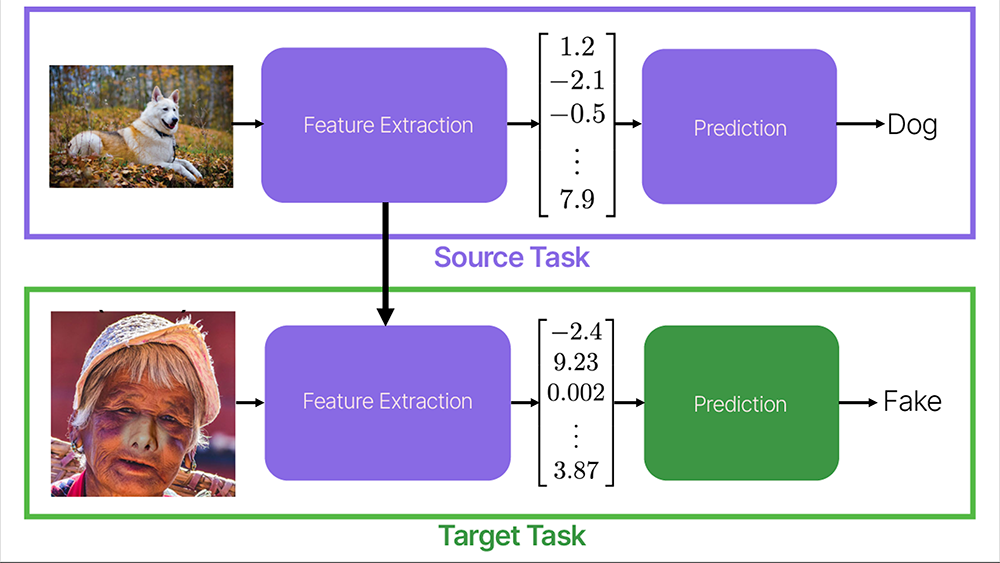

## Transfer Learning

Transfer learning utilizes pre-trained neural networks to address new, related tasks. Rather than training from scratch, it capitalizes on existing knowledge and features from models trained on larger datasets. This saves computational resources and yields impressive results even with small datasets, proving invaluable in computer vision. Recall that a CNN has two main stages:

1. **Feature Extraction**: This stage converts an image into a vector representation.
2. **Prediction**: It then uses this representation to make predictions (e.g., classifying real vs. fake).


**Issue**: The feature extraction step requires a large amount of data to learn patterns essential for accurate predictions. But our dataset - even with 140,000 images - likely isn't big enough.

**Solution**: Train a separate CNN on a massive dataset and borrow its feature extraction part for our task. This technique, called **transfer learning**, transfers the patterns used from the source task to our model.

Additional terms:
- The task where the model is trained on the large dataset is the **source task**.
- The specific task we're interested in (e.g., classifying real vs. fake faces) is the **target task**.

Despite differences between the source and target tasks, we can transfer knowledge because the feature extraction is independent of the prediction. That said, we usually want our source and target tasks to be similar to enable a more efficient transfer for the feature extractor.

## Transfer Learning From Pre-Trained Models

Here are the general steps for performing transfer learning

1. **Choose a Pre-trained Model**: Select a pre-trained convolutional neural network (CNN) model suitable for image classification tasks. Popular choices include VGG, ResNet, Inception, or MobileNet. These models are typically trained on large-scale datasets like ImageNet and have learned rich feature representations that can be useful for various computer vision tasks.

2. **Model Modification**: Repurpose the selected pre-trained model for the target prediction task by _transferring_ the feature extractor. Start by removing the original predictor layers from the pre-trained model. Then, add a new predictor on top of the feature extractor to adapt the model to the target task. Ensure that the output layer of the new predictor matches the number of classes in the target task.

3. **Determine Transfer Learning Strategy**:
   - **Train the Entire Model**: If you have a large and diverse dataset, fine-tune the entire model by updating all the model's weights during training. This approach is computationally expensive but can yield good results when sufficient labeled data is available.
   - **Fine-tune Some Layers**: If your dataset is smaller, you can selectively fine-tune only a few layers of the pre-trained model while keeping the rest frozen. Focus on training the classifier layers and possibly some of the higher layers of the feature extractor to adapt the model to the new task.
   - **Freeze the Feature Extractor**: In cases where computational resources or dataset size are limited, freeze all the layers of the pre-trained model except for the predictor layers. This approach treats the pre-trained model as a fixed feature extractor, allowing you to train only the predictor layers on your specific dataset.

4. **Training**: Split your target task dataset into training, validation, and test sets. Train the modified model using the training set while monitoring performance on the validation set to avoid overfitting. Adjust hyperparameters such as learning rate, batch size, and optimizer choice as needed to optimize model performance.

## Transfer Learning with a Pretrained Model

As an example, let's do some transfer learning using state-of-the-art models on the [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10) classification task. When we tried our own models, the best we did was about 70% - can we do better with transfer learning? Let's go step-by-step using the instructions above!

In [8]:
import torch
from torchvision import models, transforms, datasets

def get_converter():
    """
    Convert image to format fit for training a model (convert to Tensor and normalize image values for stability).

    Edit this function to change your feature engineering steps! Some things to try:
    - Select a subset of channels (e.g. only use the red and green channels)
    - Create a random crop of the image to tackle image bias
    - Create a new channel that is a combination of the other channels
    """
    pil_converter = transforms.PILToTensor()
    img_mean = torch.tensor([125.3069, 122.9501, 113.8660]).reshape((3,1,1))
    img_std = torch.tensor([51.5869, 50.8501, 51.2454]).reshape((3,1,1))
    def converter(image):
        return (pil_converter(image).to(torch.float32) - img_mean) / img_std
    return converter

In [19]:
converter = get_converter()
train_loader = datasets.CIFAR10(root="./private", download=True, train=True, transform=converter)
val_loader = datasets.CIFAR10(root="./private", download=True, train=False, transform=converter)

Files already downloaded and verified
Files already downloaded and verified


### Step 1 - Choose a Pre-trained Model

Generally, there are _many_ potential options for models that could be used for transfer learning. For this task, we'll choose the [VGG-16](https://browse.arxiv.org/pdf/1409.1556.pdf) model, but in practice you will want to research different models to get a better understanding for which models could work best.

The `torchvision` package allows us to easily download a version of the VGG-16 model that has been pre-trained on the [ImageNet ILSVRC](https://image-net.org/challenges/LSVRC/2017/index.php) source task (which is an _incredibly_ common source task). For other models, you may need to do extra research to find a pre-trained version of the architecture that works for the target task.

In [10]:

source_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Printing out the number of parameters in the VGG-16 model, we see that there are 138,357,544 parameters! This is an insanely big model (but comparatively small for modern deep learning architectures).

In [5]:
count = 0
for param in source_model.parameters():
    count += param.numel()
print(f"VGG-16 has {count} parameters")

VGG-16 has 138357544 parameters


### Step 2 - Model Modification

In this step, we'll modify the VGG-16 architecture trained on the source task to:
1. Isolate only the feature extractor
2. Add new predictor layers for the target task

Lets start by printing out the model.

In [ ]:
print(source_model)

Very helpfully, we see there are two parts (three technically, but ignore the `AvgPool2d` layer for simplicity):
- **`source_model.features`** - the feature extractor of VGG-16
- **`source_model.classifier`** - the predictor of VGG-16

Let's keep the `source_model.features` attribute the same as we want to keep the same feature extractor. However we will definitely change the predictor layers to be used for the target task. The code below defines a new set of predictor layers for use in the target task. The code below uses the `torch.nn.Sequential` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)) API to define the set of layers.

In [13]:
source_model.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1024, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 10)
)

We chose an arbitrary architecture here, but a large part of transfer learning is figuring out how you want to setup this prediction layer! Notice specifically the last layer:

```python
torch.nn.Linear(128,10)
```

The last dense layer here tells us that the output of the _new_ predictor will have 10 values - one for _each of the classes_ in the CIFAR-10 dataset used for the target task! As a follow-up then - if the target task has $k$ classes, how many output values should the final dense layer have?

To confirm that everything worked, let's go ahead and print out the _new_ model - you should see that the printed architecture should match the definition above.

In [ ]:
print(source_model)

### Step 3 - Determine Transfer Learning Strategy

There are 3 major transfer learning strategies as stated in the earlier instructions:
>    - **Train the Entire Model**: If you have a large and diverse dataset, fine-tune the entire model by updating all the model's weights during training. This approach is computationally expensive but can yield good results when sufficient labeled data is available.
>   - **Fine-tune Some Layers**: If your dataset is smaller, you can selectively fine-tune only a few layers of the pre-trained model while keeping the rest frozen. Focus on training the classifier layers and possibly some of the higher layers of the feature extractor to adapt the model to the new task.
>   - **Freeze the Feature Extractor**: In cases where computational resources or dataset size are limited, freeze all the layers of the pre-trained model except for the predictor layers. This approach treats the pre-trained model as a fixed feature extractor, allowing you to train only the predictor layers on your specific dataset.

As Google Colab has limited computational resources, let's choose to freeze the _entire_ feature extractor for now. We can freeze the layers and prevent them from training using the code below.

In [15]:
for parameter in source_model.features.parameters():
    parameter.requires_grad = False

### Step 4

Now we're good to train the modified VGG-16 model on our target task - the CIFAR-10 classification challenge. This might take a while to run since we're training on a massive number of parameters. To speed things up, we can use a GPU instead of a CPU on Google Colab.

To enable GPU usage:
1. Click on "Edit > Notebook Settings"
2. Switch from "CPU" to "T4 GPU"
3. Press "Save". You will need to re-run the previous cells.

Now PyTorch can use GPUs which are _much_ faster!

> **WARNING** - Make sure once you're done to switch back to CPU. Google closely monitors your GPU usage, and if you don't switch back to CPU they might ban you from using GPUs for a week or longer (this happened to me once when working on a class project 😔).

In [ ]:
source_model = source_model.to('cuda')

In [17]:
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Callable, Union
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
seaborn.set_theme()

def save_model(
    epoch: int,
    model: torch.nn.Module,
    checkpoint_dir: Union[str, Path],
):
    checkpoint_dir = Path(checkpoint_dir) / model.__class__.__name__
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    torch.save(
        model.state_dict(),
        checkpoint_dir / f"model_{epoch}.pt",
    )


def evaluate(
    model: torch.nn.Module, criterion: Callable, loader: DataLoader
) -> tuple[float]:
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        loss = 0.0
        for X, y in loader:
            outputs = model(X.to(device)).to("cpu")
            loss += criterion(outputs, y).detach().sum().item()
            _, predicted = torch.max(outputs.data, 1)  # get predicted digit
            total += len(y)
            correct += (predicted == y).sum().item()
    model.train()
    return correct / total, loss / total


def train_model(
    model: torch.nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int = 10,
    save_checkpoint: bool = True,
) -> dict[str, list[float]]:
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    model = model.to(device)

    for epoch in range(epochs):
        model.train()

        for X, y in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(X.to(device))
            loss = criterion(outputs, y.to(device))
            loss.backward()
            optimizer.step()

        if save_checkpoint:
            save_model(epoch, model, Path("checkpoints"))

        train_accuracy, train_loss = evaluate(model, criterion, train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        test_accuracy, test_loss = evaluate(model, criterion, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(
            f"Epoch {epoch + 1}: Loss - (Train {train_loss:.2f}/Test {test_loss:.2f}, "
            f"Accuracy - (Train {train_accuracy:.2f}/Test {test_accuracy:.2f})"
        )

    return {
        "loss": {
            "train": train_losses,
            "test": test_losses,
        },
        "accuracy": {
            "train": train_accuracies,
            "test": test_accuracies,
        },
    }


def plot_performance(history: dict[str, dict[str, list[float]]]) -> mpl.figure.Figure:
    fig, axes = plt.subplots(len(history), 1, figsize=(15, 5))
    for i, (metric, values) in enumerate(history.items()):
        train, test = values["train"], values["test"]
        axes[i].plot(train, label="train")
        axes[i].plot(test, label="test")
        axes[i].set_title(f"{metric}")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric)
        axes[i].legend()
    return fig

In [ ]:
optimizer = torch.optim.Adam(source_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

history = train_model(source_model, criterion, optimizer, train_loader, val_loader, epochs=10)

Let's see how our model performs now!

In [ ]:
plot_performance(history)


# Next Steps
You'll be doing a very similar process for our project - taking the feature extraction step for some model from ImageNet, and transfer it for use in classifying Real vs Fake faces.

For your actual solution, you will want to try a couple more things:
- Look at different predictor architectures! We use a simple one here, can you find one that works better?
- Tweak hyperparameters - play around the **learning rate**, **batch size**, and other model parameters to see if you can improve performance.
- Finetune the feature extraction - here we froze the feature extraction since it worked well, but often we also want to _slightly_ tweak these layers as well - try unfreezing some of the layers and see what happens!
- Torchvision provides models pre-trained on general datasets like ImageNet - can you find models pre-trained on source tasks that are more relevant for classifying face data?